In [1]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import calendar

In [2]:
s_path=Path.cwd()
s_prt_path=s_path.parent

objetoAPI = pydataxm.ReadDB()                    #Se almacena el servicio en el nombre objetoAPI
df =objetoAPI.get_collections()   

# df.to_csv('Collections.csv')
# df.head(5)

In [3]:
# Lectura de datos de enrtrada para el cálculo
s_parentpath=Path('C:\Alejo\EVE')
filepath=s_parentpath.joinpath(s_parentpath,'DatosEntrada.xlsx')

# Carga del nivel probabilístico del embalse
sheet_name='NEP%_mes'
NEPmes=pd.read_excel(filepath, header=0,sheet_name=sheet_name)
NEPmes=NEPmes.set_index('Embalse_Sinergox')

# Carga del nivel probabilístico de vertimiento
sheet_name='NPV%_mes'
NPVmes=pd.read_excel(filepath, header=0,sheet_name=sheet_name)
NPVmes=NPVmes.set_index('Embalse_Sinergox')

# Carga de la relación Embalse-Planta
sheet_name='Rel_Emb_Plt'
Rel_Emb_Plt=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

# Carga los parámetros del embalse
sheet_name='Par_Embalse'
Par_Emb=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

# Carga los parámetros del embalse
sheet_name='CurvaEmbalse'
Par_CurEmb=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

# Relación planta embalse
df_DataPlt=Rel_Emb_Plt.copy()
df_DataPlt=df_DataPlt[['Planta_Sinergox','CodigoSIC','Embalse_Sinergox','FC_Planta','Plt_Despacho']]
df_DataPlt=df_DataPlt.dropna().drop_duplicates()

In [4]:
# Función para asignar los días de la semana a cada fecha, si es festivo se trata como un domingo
import holidays
co_holidays = holidays.Colombia()

def typedays(row,weekday):

     if weekday==True:
          return row['Fecha'].weekday()
     else:
          if row['Fecha'] in co_holidays:
               return 3
          elif row['Fecha'].weekday()==5:
               return 2
          elif row['Fecha'].weekday()==6:
               return 3
          else:
               return 1

### Cáclculo de Embalse

In [5]:
# Descargar información de sinergox
FechaIni=dt.date(2025, 7, 1)
FechaFin=dt.date(2025, 8, 8)



In [6]:
# Unit kWh
df_VolumenU= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "VoluUtilDiarEner",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Embalse",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_VolumenU.rename(columns={'Value':'VolUtil'},inplace=True)
df_VolumenU['VolUtil'] = df_VolumenU['VolUtil']/1e6

In [7]:
# Unit kWh
df_VolUtilM3= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "VoluUtilDiarMasa",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Embalse",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_VolUtilM3.rename(columns={'Value':'VolUtilM3'},inplace=True)
df_VolUtilM3['VolUtilM3'] = df_VolUtilM3['VolUtilM3']/1e6

In [8]:
# Unit kWh
df_CapUtilEmb= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "CapaUtilDiarEner",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Embalse",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_CapUtilEmb.rename(columns={'Value':'CapUtil'},inplace=True)
df_CapUtilEmb['CapUtil'] = df_CapUtilEmb['CapUtil']/1e6

In [9]:
df_CapRec= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "CapEfecNeta",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Recurso",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_CapRec['Value'] = df_CapRec['Value']/1e3
df_CapRec.rename(columns={'Value':'CEN'},inplace=True)
df_CapRec=df_CapRec.drop(['Date'],axis=1)

In [10]:
df_CapRec=df_CapRec.drop_duplicates()

In [11]:
delta=dt.timedelta(days=1)
dFecha=FechaIni

df_NEPDay=pd.DataFrame()
df_NPVDay=pd.DataFrame()

while dFecha<=FechaFin:
    # Get the number of days in the month
    days_in_month = calendar.monthrange(dFecha.year, dFecha.month)[1]

    month=dFecha.month
    day=dFecha.day

    for ind in NEPmes.index:
        
        if ind=='PENOL':
            stop=1
        if month<12:
            NEP= max(0,min(NPVmes.loc[ind,month] ,(((NEPmes.loc[ind,month+1] - NEPmes.loc[ind,month])/days_in_month)*(day-1)) + NEPmes.loc[ind,month]))
        else:
            NEP= max(0,min(NPVmes.loc[ind,month] ,(((NEPmes.loc[ind,1] - NEPmes.loc[ind,month])/days_in_month)*(day-1)) + NEPmes.loc[ind,month]))

        df_NEPDay=pd.concat([df_NEPDay,pd.DataFrame({'Date':[dFecha],'Embalse_Sinergox':[ind],'NEP%':[NEP]})])
        df_NPVDay=pd.concat([df_NPVDay,pd.DataFrame({'Date':[dFecha],'Embalse_Sinergox':[ind],'NPV%':[NPVmes.loc[ind,month]]})])

    dFecha=dFecha + delta

df_NEPDay['Date']=pd.to_datetime(df_NEPDay['Date'])
df_NPVDay['Date']=pd.to_datetime(df_NPVDay['Date'])
# df_NEPDay.info()

In [12]:
FechaGraficas='2025-08-08'

In [13]:
# Parámetros de embalse
delta=dt.timedelta(days=1)
deltaN=dt.timedelta(days=-1)

df_data=df_VolumenU.copy()
df_data=df_data.merge(df_CapUtilEmb,left_on=['Date','Name'],right_on=['Date','Name'], how='left')[['Date','Name', 'CapUtil', 'VolUtil']]
df_data=df_data.merge(df_VolUtilM3,left_on=['Date','Name'],right_on=['Date','Name'], how='left')[['Date','Name', 'CapUtil', 'VolUtil','VolUtilM3']]
df_data=df_data.merge(df_NEPDay,left_on=['Date','Name'],right_on=['Date','Embalse_Sinergox'], how='left')[['Date','Name', 'CapUtil', 'VolUtil','VolUtilM3','NEP%']]
df_data['NEP']=df_data['CapUtil']*df_data['NEP%']
df_data=df_data.merge(df_NPVDay,left_on=['Date','Name'],right_on=['Date','Embalse_Sinergox'], how='left')[['Date','Name', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%']]

# Unir las plantas con la información de embalse inicial
df_data=df_DataPlt.merge(df_data,left_on=['Embalse_Sinergox'],right_on=['Name'], how='left')[['Date','Planta_Sinergox','Plt_Despacho','CodigoSIC','Embalse_Sinergox','FC_Planta', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%']]

# Convertir el volumen del emblase a energía en GWh para cada embalse, esto no tiene en cuenta la energía que se generaría aguas abajo en la cadena
df_data['NEM']=df_data['VolUtilM3']*df_data['FC_Planta']/3.6

# Renombrar los embalses de guatron
df_data.loc[df_data['Embalse_Sinergox'] == 'MIRAFLORES', 'FC_Planta'] = 0
df_data.loc[df_data['Embalse_Sinergox'] == 'MIRAFLORES', 'Embalse_Sinergox'] = 'TRONERAS'

# Renombrar los embalses del agregado de bogotá para agergrarlos
df_data.loc[df_data['Embalse_Sinergox'] == 'MUNA', 'FC_Planta'] = 0
df_data.loc[df_data['Embalse_Sinergox'] == 'MUNA', 'Embalse_Sinergox'] = 'AGREGADO BOGOTA'

df_data.loc[df_data['Embalse_Sinergox'] == 'CHUZA', 'FC_Planta'] = 0
df_data.loc[df_data['Embalse_Sinergox'] == 'CHUZA', 'Embalse_Sinergox'] = 'AGREGADO BOGOTA'


df_data=df_data.groupby(['Date', 'Planta_Sinergox','Plt_Despacho', 'CodigoSIC', 'Embalse_Sinergox'])[['FC_Planta','CapUtil', 'VolUtil', 'VolUtilM3', 'NEP%', 'NPV%', 'NEM']].sum()
df_data=df_data.reset_index()

df_data['NPV']=df_data['CapUtil']*df_data['NPV%']
df_data['NEP']=df_data['CapUtil']*df_data['NEP%']

df_Aux_1=df_data[['Date','Planta_Sinergox','NEM']]
df_Aux_1['Date']=df_Aux_1['Date'] + pd.to_timedelta(1, unit='D')
df_Aux_1=df_Aux_1.rename(columns={'NEM':'NEM_1'})
df_data=df_data.merge(df_Aux_1,left_on=['Date','Planta_Sinergox'],right_on=['Date','Planta_Sinergox'], how='left')[['Date','Planta_Sinergox','Plt_Despacho','CodigoSIC','Embalse_Sinergox','FC_Planta', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV','NEM','NEM_1']]

df_Aux_1=df_data[['Date','Planta_Sinergox','NPV']]
df_Aux_1['Date']=df_Aux_1['Date'] + pd.to_timedelta(1, unit='D')
df_Aux_1=df_Aux_1.rename(columns={'NPV':'NPV_1'})
df_data=df_data.merge(df_Aux_1,left_on=['Date','Planta_Sinergox'],right_on=['Date','Planta_Sinergox'], how='left')[['Date','Planta_Sinergox','Plt_Despacho','CodigoSIC','Embalse_Sinergox','FC_Planta', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV','NEM','NEM_1','NPV_1']]


df_data=df_data.merge(df_CapRec,left_on=['CodigoSIC'],right_on=['Code'], how='left')[['Date','Planta_Sinergox','Plt_Despacho','CodigoSIC','Embalse_Sinergox'
                                                                                                        ,'FC_Planta', 'CapUtil', 'VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV'
                                                                                                        ,'NEM','NEM_1','NPV_1','CEN']]


df_data['%aNPV'] = 100*(df_data['NPV']-df_data['NEM'])/df_data['NPV']
df_data.loc[df_data['%aNPV'] < 0, '%aNPV'] = 0

df_data['%aCapU']=100*(df_data['CapUtil']-df_data['NEM'])/df_data['CapUtil']




# Si tiene energía EVE o QUEVE es lo primero que se entrega al sistema
# df_data[(df_data.Name=='URRA1') & (pd.to_datetime(df_NEPDay.Date)<=pd.to_datetime('2024-10-31'))]
# df_data[(pd.to_datetime(df_data.Date)==pd.to_datetime('2024-11-05')) & (df_data.Embalse_Sinergox=='CHUZA')]
# df_data[(pd.to_datetime(df_data.Date)==pd.to_datetime('2024-10-31'))][['Date','Planta_Sinergox','Embalse_Sinergox', 'CapUtil','VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV','NEM','NEM_1','NPV_1','QEVE','EVE']]
df_data[(pd.to_datetime(df_data.Date)==pd.to_datetime(FechaGraficas))][['Date','Planta_Sinergox','Embalse_Sinergox', 'CapUtil','VolUtil','VolUtilM3','NEP%','NPV%','NEP','NPV','NEM','NEM_1','NPV_1','%aNPV','%aCapU','CEN']]


,Date,Planta_Sinergox,Embalse_Sinergox,CapUtil,VolUtil,VolUtilM3,NEP%,NPV%,NEP,NPV,NEM,NEM_1,NPV_1,%aNPV,%aCapU,CEN
798,2025-08-08,ALBAN,ALTOANCHICAYA,36.477868,2.2415,1.97,0.580000,0.72,21.157163,26.264065,2.283777,3.558983,26.264065,91.304555,93.739280,427.0
799,2025-08-08,BETANIA,BETANIA,120.614130,109.1842,666.57,0.018065,1.00,2.178836,120.614130,109.187869,109.187869,120.614130,9.473402,9.473402,540.0
800,2025-08-08,CALIMA,CALIMA1,216.846882,190.8573,374.01,0.033226,1.00,7.204913,216.846882,192.760598,192.863676,216.846882,11.107507,11.107507,132.0
801,2025-08-08,CHIVOR,ESMERALDA,1126.201440,1031.5334,533.92,0.295806,0.98,333.137652,1103.677411,1030.168978,1017.666178,1103.677411,6.660319,8.527112,1000.0
802,2025-08-08,EL QUIMBO,EL QUIMBO,1072.931200,1021.6698,2185.39,0.196129,0.99,210.432958,1062.201888,671.036141,677.109699,1062.201888,36.825932,37.457673,400.0
803,2025-08-08,GUATAPE,PENOL,4134.536496,3690.7258,930.31,0.027742,0.99,114.700045,4093.191131,1841.135174,1836.187535,4093.191131,55.019565,55.469369,560.0
804,2025-08-08,GUATRON,TRONERAS,520.467440,213.5542,64.14,0.168065,0.94,87.472108,489.239394,158.447180,165.117080,489.239394,67.613569,69.556755,512.0
805,2025-08-08,GUAVIO,GUAVIO,1447.543548,1390.2451,508.80,0.377742,0.99,546.797902,1433.068113,1391.977867,1398.160787,1433.068113,2.867292,3.838619,1250.0
806,2025-08-08,ITUANGO,ITUANGO,63.254400,14.0262,29.27,0.000000,0.00,0.000000,0.000000,14.618739,11.077678,0.000000,0.000000,76.888977,1200.0
807,2025-08-08,JAGUAS,SAN LORENZO,425.708058,398.3748,151.14,0.333226,0.93,141.856911,395.908494,99.660037,98.532482,395.908494,74.827507,76.589582,170.0


### Gráficas

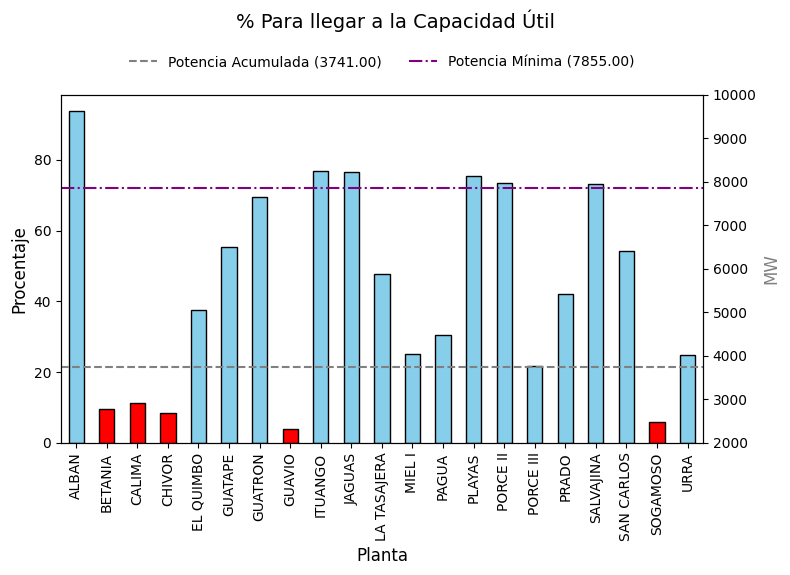

In [14]:
# Bar plot using Pandas
df_plot=df_data[(pd.to_datetime(df_data.Date)==pd.to_datetime(FechaGraficas))]

ValorCap = 20

CENSum = df_plot.loc[df_plot['%aCapU'] < ValorCap, 'CEN'].sum()

# Assign colors based on the threshold for each bar
colors_value1 = ['red' if v < ValorCap else 'skyblue' for v in df_plot['%aCapU']]

# Set the index for categories
df_plot.set_index('Planta_Sinergox', inplace=True)

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the bar chart on the primary axis
df_plot['%aCapU'].plot(kind='bar', ax=ax1, color=colors_value1, edgecolor='black')
ax1.set_ylabel('Procentaje', fontsize=12)
ax1.set_xlabel('Planta', fontsize=12)
# ax1.set_title('% Para llegar a la Capacidad Útil', fontsize=14)
# ax1.tick_params(axis='y', colors='black')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.axhline(y=CENSum, color='gray', linestyle='--', label=f'Potencia Acumulada ({CENSum:.2f})')
ax2.set_ylabel('MW', fontsize=12, color='gray')
# ax2.tick_params(axis='y', colors='gray')

# Add the second threshold line
ax2.axhline(y=7855, color='purple', linestyle='-.', label=f'Potencia Mínima ({7855:.2f})')

# Add a legend for the threshold
ax2.set_ylim(2000, 10000)  # Example: Minimum 0, Maximum 50

# Add a legend for the thresholds and move it outside
ax2.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),  # Adjust placement (centered at the top)
    ncol=2,  # Place legends in a single row with 2 columns
    frameon=False
)

# Add the title and position it above the legend
fig.suptitle(
    '% Para llegar a la Capacidad Útil', 
    fontsize=14, 
    y=0.95  # Move the title higher than the legend
)

# Show the plot
# plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# df_plot.plot(x='Planta_Sinergox', y='%aCapU', kind='bar', legend=False, color='skyblue')
# # Add labels and title
# plt.xlabel('Planta')
# plt.ylabel('Porcentaje')
# plt.title('% Para llegar a la Capacidad Útil')
# plt.show()

In [15]:
df_data

,Date,Planta_Sinergox,Plt_Despacho,CodigoSIC,Embalse_Sinergox,FC_Planta,CapUtil,VolUtil,VolUtilM3,NEP%,NPV%,NEP,NPV,NEM,NEM_1,NPV_1,CEN,%aNPV,%aCapU
0,2025-07-01,ALBAN,ALBAN,ALBG,ALTOANCHICAYA,4.1734,36.506722,13.5391,11.890,0.690000,0.69,25.189638,25.189638,13.783813,NaN,NaN,427.0,45.279830,62.243083
1,2025-07-01,BETANIA,BETANIA,CHBG,BETANIA,0.5897,120.614130,118.1132,721.082,0.000000,0.98,0.000000,118.201847,118.117238,NaN,NaN,540.0,0.071581,2.070149
2,2025-07-01,CALIMA,CALIMA,CLMG,CALIMA1,1.8554,219.014076,183.2659,355.580,0.040000,1.00,8.760563,219.014076,183.261981,NaN,NaN,132.0,16.324108,16.324108
3,2025-07-01,CHIVOR,CHIVOR,CHVR,ESMERALDA,6.9460,1124.685848,1069.3391,554.234,0.000000,0.97,0.000000,1090.945273,1069.363712,NaN,NaN,1000.0,1.978244,4.918897
4,2025-07-01,EL QUIMBO,EL QUIMBO,QUI1,EL QUIMBO,1.1054,1080.734336,1052.6645,2235.431,0.000000,0.99,0.000000,1069.926993,686.401508,NaN,NaN,400.0,35.845949,36.487490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,2025-08-08,PRADO,PRADO,PRDO,PRADO,0.4906,90.058353,52.7054,382.200,0.118710,0.75,10.690798,67.543765,52.085367,52.349746,67.543765,51.0,22.886492,42.164869
815,2025-08-08,SALVAJINA,SALVAJINA,SLVJ,SALVAJINA,0.8647,511.489242,405.7070,567.740,0.565484,1.00,289.238917,511.489242,136.367994,136.516914,511.489242,315.0,73.339030,73.339030
816,2025-08-08,SAN CARLOS,SAN CARLOS,SNCR,PUNCHINA,5.3661,65.869664,30.2227,20.170,0.000000,0.82,0.000000,54.013124,30.065066,38.352709,54.013124,1240.0,44.337481,54.356734
817,2025-08-08,SOGAMOSO,SOGAMOSO,SOG1,TOPOCORO,1.3855,1020.304901,945.6063,2496.980,0.527742,0.97,538.457683,989.695754,960.990497,959.189347,989.695754,819.0,2.900412,5.813400


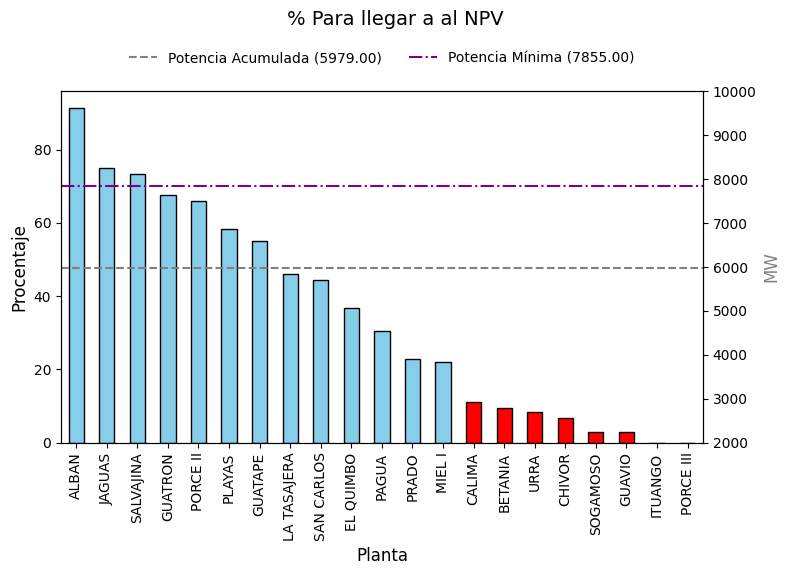

In [16]:
df_data = df_data.sort_values(by='%aNPV',ascending=False)
# Bar plot using Pandas
df_plot=df_data[(pd.to_datetime(df_data.Date)==pd.to_datetime(FechaGraficas))]

ValorCap = 20

CENSum = df_plot.loc[df_plot['%aNPV'] < ValorCap, 'CEN'].sum()

# Assign colors based on the threshold for each bar
colors_value1 = ['red' if v < ValorCap else 'skyblue' for v in df_plot['%aNPV']]

# Set the index for categories
df_plot.set_index('Planta_Sinergox', inplace=True)

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the bar chart on the primary axis
df_plot['%aNPV'].plot(kind='bar', ax=ax1, color=colors_value1, edgecolor='black')
ax1.set_ylabel('Procentaje', fontsize=12)
ax1.set_xlabel('Planta', fontsize=12)
# ax1.set_title('% Para llegar a la Capacidad Útil', fontsize=14)
# ax1.tick_params(axis='y', colors='black')

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.axhline(y=CENSum, color='gray', linestyle='--', label=f'Potencia Acumulada ({CENSum:.2f})')
ax2.set_ylabel('MW', fontsize=12, color='gray')
# ax2.tick_params(axis='y', colors='gray')

# Add the second threshold line
ax2.axhline(y=7855, color='purple', linestyle='-.', label=f'Potencia Mínima ({7855:.2f})')

# Add a legend for the threshold
ax2.set_ylim(2000, 10000)  # Example: Minimum 0, Maximum 50

# Add a legend for the thresholds and move it outside
ax2.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),  # Adjust placement (centered at the top)
    ncol=2,  # Place legends in a single row with 2 columns
    frameon=False
)

# Add the title and position it above the legend
fig.suptitle(
    '% Para llegar a al NPV', 
    fontsize=14, 
    y=0.95  # Move the title higher than the legend
)

# Show the plot
# plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
# Create a DataFrame with dates from 2025-07-01 to 2027-12-31
dates = pd.date_range(start='2025-07-01', end='2027-12-31', freq='D')
df_dates = pd.DataFrame({'Fecha': dates})
# Definir tipo de día
df_dates['day_osf']=df_dates.apply(lambda row: typedays(row,weekday=False),axis=1)

df_dates.to_csv('Fachas.csv')